# Cumulative emissions

In [1]:
import concurrent.futures
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
from oc_pyclient import Client
import pandas as pd

In [2]:
client = Client(dev=True)

## 1. Get country codes

In [3]:
df_country = client.parts('EARTH')
iso_codes = df_country['actor_id']

## 2. Get emissions for all countries

In [4]:
%%time
def process_emission(country=None, dataset='PRIMAP-hist_v2.4_ne'):
    df_tmp = client.emissions(country)
    filt = df_tmp['dataset'] == dataset
    df_tmp = df_tmp.loc[filt]
    df_agg = (
        df_tmp[['year','total_emissions']]
        .sort_values('year')
        .assign(
            diff_emissions=df_tmp["total_emissions"].diff(),
            cumulative_emissions=df_tmp["total_emissions"].cumsum(),
            country=country
        )
    )
    return df_agg

dataset = 'PRIMAP-hist_v2.4_ne'
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(process_emission, country, dataset=dataset)
               for country in iso_codes]
    data = [f.result() for f in concurrent.futures.as_completed(results)]
    
df_out = pd.concat(data)

CPU times: user 4.73 s, sys: 610 ms, total: 5.34 s
Wall time: 13.4 s


## 3. list of top emitters

In [5]:
n_countries = 7
top_emitters = (
    df_out.loc[df_out['year']==2021, ['cumulative_emissions', 'country']]
    .sort_values(by='cumulative_emissions', ascending=False)
    .head(n_countries)['country']
)

## 4. Plot cumulative emissions

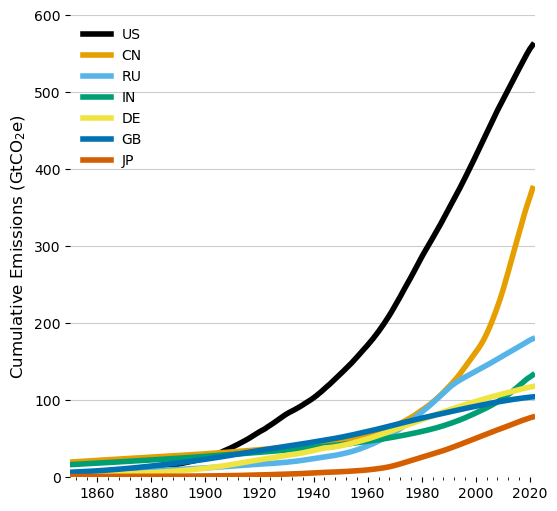

In [6]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# wong color palette (https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40)
colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

for country, color in zip(top_emitters, cycle(colors)):
    filt = df_out['country'] == country
    df_tmp = df_out.loc[filt]

    ax.plot(df_tmp['year'], df_tmp['cumulative_emissions']/10**9, 
            linewidth=4, 
            label=country,
            color=color)

    ylim = [0, 600]
    ax.set_ylim(ylim)
    ax.set_xlim([1850, 2022])

    # Turn off the display of all ticks.
    ax.tick_params(which='both',     # Options for both major and minor ticks
                   top='off',        # turn off top ticks
                   left='off',       # turn off left ticks
                   right='off',      # turn off right ticks
                   bottom='off')     # turn off bottom ticks

    # Remove x tick marks
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # major/minor tick lines
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(axis='y', 
            which='major', 
            color=[0.8, 0.8, 0.8], linestyle='-')

    ax.set_ylabel("Cumulative Emissions (GtCO$_2$e)", fontsize=12)
    ax.legend(loc='upper left', frameon=False)